In [1]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory
import seaborn as sns
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(1991)
torch.manual_seed(1991)
torch.cuda.manual_seed(1991)

import random
random.seed(1991)

import numpy as np
np.random.seed(1991)

Running on device: CUDA


In [2]:
# CIFAR 10 dataset
torch.manual_seed(1991)
# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 15573427.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [37]:
from sklearn.linear_model import LogisticRegression

def train_mia_on_class(model, class_index, train_set, test_set):
  model = model.to("cpu")

  # Select indencies where class is class_index
  train_class_set = np.where(np.array(train_set.targets) == class_index)[0]
  test_class_set = np.where(np.array(test_set.targets) == class_index)[0]

  max_len = min([len(train_class_set), len(test_class_set)])
  # Make equal sizes
  train_class_set = train_class_set[:max_len]
  test_class_set = test_class_set[:max_len]

  # Obtain subsets
  train_class_set = torch.utils.data.Subset(train_set, train_class_set)
  test_class_set = torch.utils.data.Subset(test_set, test_class_set)


  # Make them
  class_test_loader = torch.utils.data.DataLoader(
    test_class_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )

  class_train_loader = torch.utils.data.DataLoader(
    train_class_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )

  criterion = nn.CrossEntropyLoss(reduction="none")
  # Obtain train and test logits
  logits_train = []
  for i, (images, labels) in enumerate(class_train_loader, 0):
    for img, label in zip(images, labels):
      logits = model(img.unsqueeze(0))
      losses = criterion(logits, label.unsqueeze(0)).numpy(force=True)

      logits_train.append(np.concatenate((logits.detach().numpy()[0], losses)))

  logits_test = []
  for i, (images, labels) in enumerate(class_test_loader, 0):
    for img, label in zip(images, labels):
      logits = model(img.unsqueeze(0))
      losses = criterion(logits, label.unsqueeze(0)).numpy(force=True)

      logits_test.append((np.concatenate((logits.detach().numpy()[0], losses))))

  logits_train, logits_test = np.array(logits_train), np.array(logits_test)
  # Create dataset
  ys = [1] * 1000 + [0] * 1000
  ys = np.array(ys)
  p = np.random.permutation(len(ys))
  logits = np.concatenate((logits_train, logits_test))

  logits = logits[p]
  ys = ys[p]

  # Fit logitstic regression
  clf = LogisticRegression(random_state=0, max_iter=1000)
  cv = model_selection.StratifiedShuffleSplit(
        n_splits=5, random_state=0
    )

  clf = model_selection.cross_val_score(
        clf, logits, ys, cv=cv, scoring="accuracy"
    )

  # Output score
  print(f"Mean MIA attack score for class {class_index} is: " + str(clf.mean()))
  return clf.mean()

In [43]:
def draw_plot(MIA_attack_results, model_name):
  fig = plt.figure()

  ax = fig.add_subplot(111)
  ax.axhline(y=np.round(np.mean(np.array(MIA_attack_results)), 3), label='Середнє значення MIA attack', color='gray', linestyle='--')

  ax.plot(MIA_attack_results, 'o', color='gray')

  ax.set_title(f"{model_name} MIA attack results")
  ax.set_xlabel("Клас")
  ax.set_ylabel("MIA attack result")

  for i,j in enumerate(MIA_attack_results):
      ax.annotate(str(j),xy=(i,j))

  plt.text(4, np.round(np.mean(np.array(MIA_attack_results)), 3), f'Mean: {np.round(np.mean(np.array(MIA_attack_results)), 3)}', fontsize=10, va='center', ha='center', backgroundcolor='w')

  ax.set_xticks(range(10))
  plt.show()

Mean MIA attack score for class 0 is: 0.576
Mean MIA attack score for class 1 is: 0.585
Mean MIA attack score for class 2 is: 0.648
Mean MIA attack score for class 3 is: 0.6529999999999999
Mean MIA attack score for class 4 is: 0.621
Mean MIA attack score for class 5 is: 0.6460000000000001
Mean MIA attack score for class 6 is: 0.569
Mean MIA attack score for class 7 is: 0.561
Mean MIA attack score for class 8 is: 0.539
Mean MIA attack score for class 9 is: 0.5890000000000001


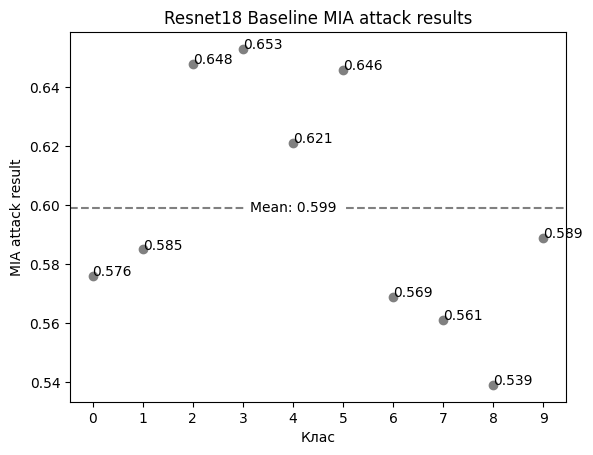

In [44]:
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

model = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model.load_state_dict(torch.load(model_params))
model.eval()
model = model.to("cpu")


MIA_attack_results = []
for class_index in np.unique(train_set.targets):
  MIA_attack_result = train_mia_on_class(model, class_index, train_set, test_set)
  MIA_attack_results.append(MIA_attack_result)

MIA_attack_results = np.round(np.array(MIA_attack_results), 3)
draw_plot(MIA_attack_results, model_name)

Mean MIA attack score for class 0 is: 0.526
Mean MIA attack score for class 1 is: 0.523
Mean MIA attack score for class 2 is: 0.544
Mean MIA attack score for class 3 is: 0.5589999999999999
Mean MIA attack score for class 4 is: 0.55
Mean MIA attack score for class 5 is: 0.526
Mean MIA attack score for class 6 is: 0.5370000000000001
Mean MIA attack score for class 7 is: 0.5029999999999999
Mean MIA attack score for class 8 is: 0.501
Mean MIA attack score for class 9 is: 0.5279999999999999


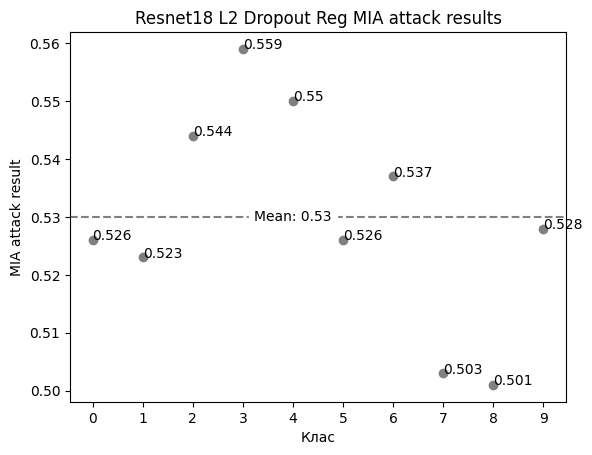

In [45]:
model_name = "Resnet18 L2 Dropout Reg"
model_params = "cifar10_resnet18_l2_dropout_regularization (1).pt"

model = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch

from collections import OrderedDict

layer1 = model.layer1

for indx in range(len(layer1)):
  modified_layers = OrderedDict()
  for name, feature in layer1[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)

  model.layer1[indx] = nn.Sequential(modified_layers)



layer2 = model.layer2

for indx in [1]:
  modified_layers = OrderedDict()
  for name, feature in layer2[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)

  model.layer2[indx] = nn.Sequential(modified_layers)

layer3 = model.layer3

for indx in [1]:
  modified_layers = OrderedDict()
  for name, feature in layer3[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)
  model.layer3[indx] = nn.Sequential(modified_layers)

layer4 = model.layer4

for indx in [1]:
  modified_layers = OrderedDict()
  for name, feature in layer4[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)

  model.layer4[indx] = nn.Sequential(modified_layers)


model.load_state_dict(torch.load(model_params))
model.eval()
model = model.to("cpu")


MIA_attack_results = []
for class_index in np.unique(train_set.targets):
  MIA_attack_result = train_mia_on_class(model, class_index, train_set, test_set)
  MIA_attack_results.append(MIA_attack_result)

MIA_attack_results = np.round(np.array(MIA_attack_results), 3)
draw_plot(MIA_attack_results, model_name)

Mean MIA attack score for class 0 is: 0.528
Mean MIA attack score for class 1 is: 0.516
Mean MIA attack score for class 2 is: 0.53
Mean MIA attack score for class 3 is: 0.5389999999999999
Mean MIA attack score for class 4 is: 0.5609999999999999
Mean MIA attack score for class 5 is: 0.5199999999999999
Mean MIA attack score for class 6 is: 0.481
Mean MIA attack score for class 7 is: 0.542
Mean MIA attack score for class 8 is: 0.51
Mean MIA attack score for class 9 is: 0.521


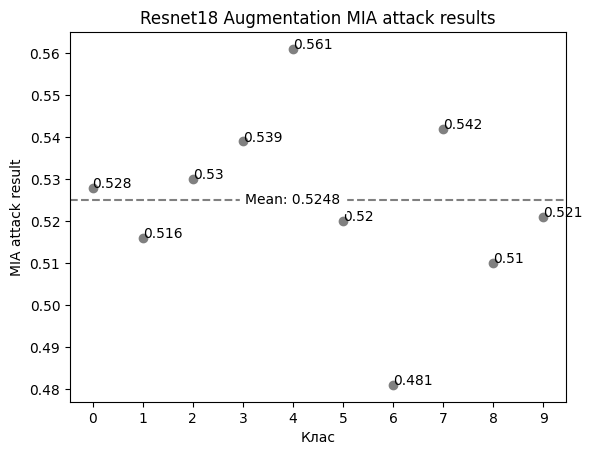

In [38]:
model_name = "Resnet18 Augmentation"
model_params = "cifar10_resnet18_augmentation.pt"

model = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model.load_state_dict(torch.load(model_params))
model.eval()
model = model.to("cpu")


MIA_attack_results = []
for class_index in np.unique(train_set.targets):
  MIA_attack_result = train_mia_on_class(model, class_index, train_set, test_set)
  MIA_attack_results.append(MIA_attack_result)

MIA_attack_results = np.round(np.array(MIA_attack_results), 3)
draw_plot(MIA_attack_results, model_name)